In [27]:
from IPython.display import Image

# CNTK 101: Логический регрессионный анализ (LR) и ML Primer

Это пособие направлено на новичков в машинном обучении, решивших начать свой путь с CNTK. После изучения материала, вы сможете обучать простые, однако достаточно мощные модели машинного обучения, используемые в науке и промышленности в самых разнообразных задачах. Модель обучается на массиве данных наиболее быстрым способом, основываясь на доступных вам вычислительных мощностях (один или нескольлко CPU, GPU или кластер из CPU или GPU), прозрачно основываясь на возможностях библиотеки CNTK.

## Введение

**Задача**:
Онкологической больницей предоставлены данные и пожелания по выявлению пациентов с потенциальным смертельным исходом (злокачественным раком) или с доброкачественной опухолью. Подобные задачи называются задачами классификации. Для упрощения классификации, для каждого пациента указывается возраст и размер опухоли. Интуитивно понятно, что у молодых пациентов или пациентов с маленькой опухолью меньше шансов иметь злокачественную опухоль, чем у пожилых пациентов и/или пациентов с большой опухолью. Набор данных имитирует эту задачу, каждый пациент обозначен точкой на плоскости возраст-размер (приведенной ниже), где синий цвет указывает на доброкачественную опухоль, а красный на рак.
Примечание: Этот пример является сильно упрощенным для использования в обучении новичков. В реальных задачах используется значительно больше параметров, таких как различные тесты, опыт врачей, занимающихся диагностикой и лечением больных.

In [28]:
# Рисунок 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**Цель**:
Конечной целью является обучение классификатора для автоматического определения принадлежности пациента к группе риска (рак или доброкачественная опухоль) на основе двух признаков: возраста и размера опухоли. В этом примере синтезируется линейный классификатор, являющийся одним из базовых для глубинных сетей.

In [29]:
# Рисунок 3
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

На рисунке выше (Рис. 3) зеленая линия представляет обученную на этих данных модель и разделяющая синие и красные точки. В этом пособии мы рассмотрим шаги по обучению "зеленой линии".
Заметка: этот классификатор делает ошибки, оставляя несколько синих точек на "красной" стороне. Несмотря на это имеется возможноость избежать этого. Эти методы будут рассмотрены в дальнейшем.

**Предпосылки**: 
Любой алгоритм обучения обычно имеет пять этапов. Это чтение данных, предобработка данных, создание модели, обучение модели (настройка параметров) и верификация (тестирование) модели.

>1. Чтение данных: Генерируется имитирующий набор данных, содержащий для каждого элемента два признака (возраст и размер).
>2. Предобработка данных: Часто индивидуальные особенности такие как размер или возраст необходимо нормировать. Обычно это диапазон от 0 до 1. Для простоты сейчас нормализация производится не будет. (Подробнее сморти тут: [функция нормировки][]).
>3. Создание модели: Введем базовую линейную модель. 
>4. Обучение модели: Обычно это называется обучением. Однако для настройки линейных моделей существует множество способов ([линейная регрессия][]), в CNTK используется метод стохастического градиентного спуска [SGD][].
>5. Верификация: также известна, как тестирование. Заключается в проверке на данных с известными результатами, которые не были использованы при обучении.Это позволяет оценить, как модель будет работать на реальных (ранее не известных) данных.

## Логическая регрессия
[Логическая регрессия][] это базовая методика машинного обучения, которая использует линейную взвешенную комбинацию функций и получает вероятность предсказания различных классов. В нашем случае классификатор генерирует вероятность [0,1], которую затем можно сравнить с пороговым значением (например, 0,5) для получения бинарной метки (0 или 1). Тем не менее, этот способ может быть легко расширен на большее количество классов.
[функция нормировки]: https://en.wikipedia.org/wiki/Feature_scaling
[SGD]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[линейная регрессия]: https://en.wikipedia.org/wiki/Linear_regression
[Логическая регрессия]: https://en.wikipedia.org/wiki/Logistic_regression

In [30]:
# Рисунок 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

На рисунке выше показано, как значения различных входов (признаков) линейно складываются. Результирующая сумма подается на [сигмоидную][] функцию активации нейрона, имеющую область значений [0;1]. Для классификаторов, имеющих более, чем два результирующих класса можно использовать [softmax][] функцию активации.
[сигмоидную]: https://en.wikipedia.org/wiki/Sigmoid_function
[softmax]:https://en.wikipedia.org/wiki/Softmax_function

In [31]:
# Загрузка необходимых компонентов
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (требуется только для нашей системы сборки)
C.cntk_py.set_fixed_random_seed(1) # перемешаем, чтобы примеры LR не повторялись


## Генерация данных
Теперь сгенерируем искусственный набор данных, имитирующий выборку раковых пациентов с помощь библиотеки `numpy`. Имеются два признака (два измерения) пациента (точки), принадлежащих в одному из двух классов (доброкачественные: синяя точка или злокачественными: красная точка).

В нашем примере, каждое наблюдение из обучающих данных, имеет метку (синие или красное), соответствующую каждому наблюдению (набор функций - возраст и размер). В этом примере два класса, представленных метками 0 или 1, таким образом имеется задача бинарной классификации.

In [32]:
# Определение сети
input_dim = 2
num_output_classes = 2

### Входы и выходы

В этом пособии мы генерируем синтетические данные, используя библиотеку `numpy`. При решении реальной задачи, как правило используется [reader][], который считывает значения функций (`признаки`: *возраст* and *размер опухоли*) для каждого элемента набора данных (пациента). Имитируемая переменная *возраст* нормируется для того, чтобы иметь такой же диапазон, как и остальные признаки.  Это ключевой аспект предварительной обработки данных, который будет рассмотрен в последующих статьях. Обратите внимание, что каждое наблюдение может иметь более высокую размерность пространства (когда доступно больше функций) и будут представлен в виде [тензора][] в CNTK. Более продвинутые учебные пособия помогуть постигнуть обработку данных высокой размерности.

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[тензора]: https://en.wikipedia.org/wiki/Tensor

In [33]:
# Убедитесь, что мы всегда получаем одинаковую пресдослучаюную последовательность
np.random.seed(0)

# Вспомогательная функция для генерации случайных данных
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Создание синтетических данных с использованием NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Делаем данные разделимыми
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    # Укажите тип данных, соответствующий входной переменной используемой позже в статье 
    # (по умолчанию double)
    X = X.astype(np.float32)    
    
    # преобразуем класс 0 в вектор "1 0 0", 
    # класс 1 в вектор "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [34]:
# Создайте входные переменные, обозначающие функции и данные разметки. Заметка: input_variable 
# не нужна дополнительная информация о количестве наблюдений(выборок), т.к. CNTK сначала создает 
# только топологию сети. 
mysamplesize = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

Теперь визуализируем входные данные.

**Заметка**: Если у вас ошибка при импорте `matplotlib.pyplot`, выполните команду `conda install matplotlib` которая исправит зависимости версий `pyplot`. Если вы используете окружение python отличное от Anaconda, используйте `pip install`.

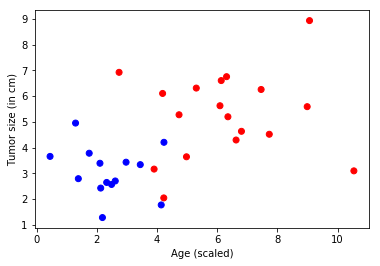

In [35]:
# Построим график
import matplotlib.pyplot as plt
%matplotlib inline

# Разделим на 2 класса 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

# Создание модели

Сеть логической регрессии (далее LR) является самым простым строительным блоком, однако использовалась во многих задачах в последнее десятилетие. LR является простой линейной моделью, которая принимает в качестве входных данных вектор чисел, описывающий свойства того, что необходимо классифицировать (также известный как вектор функция $\bf{x}$, синие узлы на рисунке) и возвращает степень активации нейрона ($z$) (выход зеленого узла). Каждая функция во входном слое соединена с выходным узлом с помощью соответствующего веса w (обозначается черными линиями различной толщины).

In [36]:
# Рисунок 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

Первым шагом является вычисление признаков для наблюдений.

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

где $\bf{w}$ вес вектора $n$ и $b$ называемый термином [bias][]. Заметка: **жирный** шрифт используется для обозначения векторов. 

Выход сети имеет диапазон 0-1 благодаря использованию функции [`сигмоида`][] (когда выход может иметь два значения) или функции `softmax` (когда выход должен отражать более 2-х классов).

Входы и выходы сети: 
- Переменная **input** (ключевое понятие CNTK): 
>Переменная **input** в пользовательском коде представляет контейнер, содержащий или представляющий данные о наблюдениях(точки или элементы данных, эквивалентные красным и синим точкам в нашем эксперимете) в качестве входов в процессе обучения или тестирования модели. Таким образом формат `input_variable` должен соответствовать формату данных, которые будут использоваться.  Например, для изображений высотой 10 пикселей и шириной 5 пикселей, размерность входной функции будет 2 (представляющие высоту и ширину изображения). Аналогично в рассматриваемой модели это возраст и размер опухоли, т.о. `input_dim` = 2. Более подробно о данных и их размерность в отдельных руководствах.

[bias]: https://www.quora.com/What-does-the-bias-term-represent-in-logistic-regression

[`сигмоида`]: https://en.wikipedia.org/wiki/Sigmoid_function

In [37]:
feature = C.input_variable(input_dim, np.float32)

## Настройка сети

Функция `linear_layer` является прямой реализацией уравнения выше. Выполним две операции:
0. Умножение весов ($\bf{w}$) на функции ($\bf{x}$) используя оператор CNTK `times` и добавим вклад индивидуальных особенностей,
1. Добавим смещение (bias) $b$.

Эти операции CNTK оптимизированы для выполнения на доступных аппаратных средствах и сложность их реализации скрыта от пользователя. 

In [38]:
# Определить словарь для хранения параметров модели
mydict = {}

def linear_layer(input_var, output_dim):
    
    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    return C.times(input_var, weight_param) + bias_param

`z` будет использоваться для представления выходного сигнала сети.

In [39]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

### Обучение параметров модели

Когда нейронная сеть настроена, можно приступить к настройке параметров $\bf w$ И $b$ для нашего простого линейного слоя. Для этого преобразуем полученные выходы ($z$) в набор предсказанных степеней принадлежности ($\textbf p$) с помощью функции `softmax`.

$$ \textbf{p} = \mathrm{softmax}(z)$$ 

`softmax` является функцией активации, которая отображает накопленные доказательства для распределения степени принадлежности классам (Подробнее о [softmax функции][]). Другие варианты функции активации можно [найти здесь][].

[softmax функции]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[найти здесь]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Обучение
Выход функции `softmax` является степенью приналежности наблюдений определенным классам. Для обучения классификатора, необходимо определить, какое поведение модель должна имитировать. Другими словами, мы хотим, чтобы сформированные степени принадлежности были как можно ближе к наблюдаемым меткам. Эта функция называется функцией *стоимости* или *потери* и показывает разницу между обучаемой моделью и сгенерированной из обучающего набора.

[Перекрестная энтропия][] является популярной функцией для определения функции ошибки. Она определяется как:

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$  

где $p$ предсказанная степень принадлежности функцией `softmax` а $y$ представляет метку класса. Эта метка должна иметь известные данными для обучения. В примере с двумя классами, переменная `label` имеет размер 2 (равный `num_output_classes` или $C$). Вообще говоря, если задача требует классификации в $C$ различных классов, переменная label будет иметь $C$ элементов с 0 для всех классов кроме верного, который будет 1.  Рекомендуем ознакомится для понимания [деталей][] функции перекрестной энтропии.

[Перекрестная энтропия]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[деталей]: http://colah.github.io/posts/2015-09-Visual-Information/

In [40]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

#### Определение качества

Для того, чтобы оценить качество классификации, можно сравнить выход сети с истинными значениями (могут быть преобразованы в степени принадлежности с помощью функции `softmax`) с размерностью равной числу классов.

In [41]:
eval_error = C.classification_error(z, label)

### Продолжение обучения

"Учитель" стремится найти минимум функции `потери` с помощью различных методов оптимизации, [Стохастический градиентный спуск][] (`sgd`) является одним из самых популярных. Обычно, параметры модели инициализируются случайным образом. Оптимизатор `sgd` вычисляет функцию `потери` или ошибку между предсказанной принадлежностью и истинной и с помощью [градиентного спуска][] генерирует новые параметры модели. 

Обновление параметров модели с использованием одного наблюдения является привлекательным, так как не требует загружать в память весь набор данных, а также требует вычисления градиента в меньшем числе точек, что позволяет обеспечить обучение на большом наборе данных. Несмотря на это, обновления генерируемые с помощью одного образца данных могут сильно отличаться друг от друга между итерациями. Поэтому иногда загружается небольной набор наблюдений и используется среднее значение функции `потери` или ошибки для этого набора данных. Такая подвыборка называется *minibatch*.

Подвыборки часто используются при наличии большого набора данных для обучения. Процесс обновления параметров модели повторяется несколько раз с использованием различных комбинаций данных для подвыборок и минимизирует `потерю` (и ошибку). Когда значение ошибки значительно не изменяется на протяжении некоторого времени, можно утверждать, что модель обучена.

Один из ключевых параметров для оптимизации называется `learning_rate` (коэффициент обучения). Сейчас можно воспринимать его, как коэффициент масштабирования, определяющий скорость изменения параметров в каждой итерации. Более подробно рассмотрим в следующих статьях. 

Основываясь на этой информации, приступим к созданию тренера.

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Стохастический градиентный спуск]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[градиентного спуска]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [42]:
# Создание объекта тренера, для обучения модели
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

Сначала создадим некоторые вспомогательные функции, которые будут необходимы для визуализации данных, связанных с обучением. Обратите внимание на то, что эти функции предназначены для упрощения понимания процесса обучения.

In [43]:
# Определим служебную функцию для вычисления скользящей средней суммы.
# Более эффективная реализация возможна с функцией np.cumsum()
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Определяем функцию, которая выводит прогресс обучения
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

### Запуск обучения

Сейчас мы готовы к запуску обучения нашей логической регрессионной модели. Необходимо решить, какие данные будут использоваться для обучения.

В этом примере каждая итерация оптимизатора работает на 25 элементах (25 точек на графике выше) `minibatch_size`. Предположим, что мы хотим обучать модель на 20000 наблюдений. Если число выборок только 10000, учитель дважды будет использовать эти данные. Это значение хранится в `num_minibatches_to_train`. 

Заметка: В реальном случае, мы бы взяли определенное количество размеченных данных (в контексте примера — наблюдения (возраст, размер) и что они обозначают (доброчачественная/злокачественная)). И сказали бы, что будем использовать, допустим, 70% набора для обучения и остаток для оценки качества обучения.

С помощью этих параметров мы можем продолжить обучение нашей простой сети прямого распространения (feedforward network).

In [44]:
# Инициализируем параметры тренера
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [45]:
from collections import defaultdict

# Запустим учителя и веведем данные обучения
training_progress_output_freq = 50
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Укажите отображение входных переменных в модели с фактическими данными minibatch для обучения
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)
        

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 4.4290, Error: 0.36
Minibatch: 100, Loss: 0.4585, Error: 0.16
Minibatch: 150, Loss: 0.7228, Error: 0.32
Minibatch: 200, Loss: 0.1290, Error: 0.08
Minibatch: 250, Loss: 0.1321, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1076, Error: 0.04
Minibatch: 400, Loss: 0.3087, Error: 0.08
Minibatch: 450, Loss: 0.3219, Error: 0.12
Minibatch: 500, Loss: 0.4076, Error: 0.20
Minibatch: 550, Loss: 0.6784, Error: 0.24
Minibatch: 600, Loss: 0.2988, Error: 0.12
Minibatch: 650, Loss: 0.1676, Error: 0.12
Minibatch: 700, Loss: 0.2772, Error: 0.12
Minibatch: 750, Loss: 0.2309, Error: 0.04


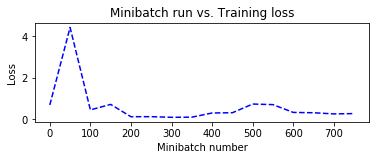

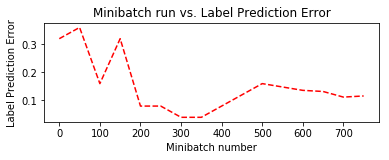

In [46]:
# Вычисление скользящей средней потери, чтобы сгладить шум в SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Построение потери обучения и ошибки обучения
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Оценка качества / Тестирование 

После обучения сети оценим качество обучения с помощью данных, не использованных при обучении. Это называется **проверка**. Давайте создадим новый набор данных и оценим среднюю ошибку и потерю на этом множестве. Это можно сделать с помощью `trainer.test_minibatch`. Обратите внимание, что полученная ошибка должна быть сопоставима с ошибкой обучения, что является ключевым признаком правильности обучения. Если ошибка проверки значительно больше ошибки обучения, то модель будет плохо работать на данных, которые не использовались при обучении. Такой эффект известен как [overfitting][] (переобучение). Есть несколько способов, выходящих за рамки данного руководства, избежать этого, однако Cognitive Toolkit предоставляет все необходимые инструменты.

Заметка: Мы тестируем на одной подвыборке. На практике используется несколько подвыборок тестовых данных и рассматривается средее значение. 

[overfitting]: https://en.wikipedia.org/wiki/Overfitting


In [47]:
# Запустите обученную модель на вновь сгенерированном наборе данных
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels}) 

0.12

### Проверка прогнозирования / оценки
Для оценки мы используем выход сети в диапазоне 0-1 и преобразуем его в принадлежность двум классам. Это говорит о возможности каждого наблюдения быть злокачественными и доброкачественными. Мы используем функцию softmax, для получения вероятности каждого класса.

In [48]:
out = C.softmax(z)
result = out.eval({feature : features})

Давайте сравним истинное значение класса элементов выборки с предсказаниями. Они должны быть эквивалентными.

**Вопрос:** 
- Сколько предсказаний были неверными? Можно ли изменить код, приведенный ниже, чтобы определить, какие наблюдения были неправильно классифицированы?

In [49]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result[0]])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [0, 0]


### Визуализация
Желательно визуализировать результаты. В этом примере данные удобно представить в двух измерениях. При получении данных с более высокими размерностями, визуализация может быть сложной задачей. Есть передовые методы снижения размерности, которые позволяют визуализацию таких данных. [t-sne][].

[t-sne]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

[ 7.99141502 -7.99141407]


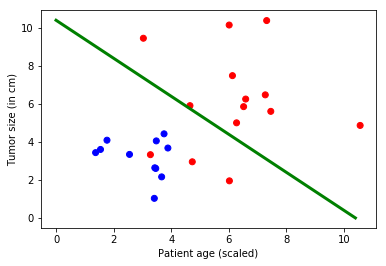

In [50]:
# Параметры модели
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# построение данных
import matplotlib.pyplot as plt

# с учетом того, что это 2 класса 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

**Предложение для самостоятельного исследования** 
- Попробуйте исследовать, как классификатор ведет себя с различными распределениями данных 
- Изменените параметр `minibatch_size` в диапазоне от 25 до 64. Почему растет ошибка? 
- Попробуйте исследовать различные функции активации 
- Попробуйте исследовать различных учителей 
- Вы можете изучить обучение классификатора [мультиклассовой логистической регрессии][].

[мультиклассовой логистической регрессии]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

### Дополнение
Многие термины в литературе машинного обучения могут быть трудно сопоставлены. Каждый инструментарий / книга / документ имеют свое отношение к синонимичным терминам. Вот несколько терминов CNTK и их эквивалентные термины в литературе:

- "sequence" - последовательность (в CNTK) также упоминается как экземпляр - "instance"
- "sample" - образец (в CNTK) также упоминается как функция - feature
- "input stream(s)" - входной поток(и) (в CNTK) также упоминается как столбец функций или функция - "feature column" или "feature"
- "criterion" - критерий (в CNTK) также упоминается как потеря - "loss"
- "evalutaion error" ошибка  (в CNTK) также упоминается как метрика - "metric"